In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import savgol_filter
import ipywidgets as widgets
%matplotlib inline

In [2]:
def kmeans_elbow(data: np.ndarray, num_cluster: int,title_name:str):
    '''
    Calculates the sum of squares for different number of clusters using K-means
    This allows to select an optimal number of cluster
    '''
    sum_squares = np.zeros(len(range(2, num_cluster+1)))
    silho_coeff = np.zeros(len(range(2, num_cluster+1)))
    j=0
    for i in range(2, num_cluster+1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
        print("Num cluster:", i, "Sum of squares:", kmeans.inertia_)
        sum_squares[j] = kmeans.inertia_
        j+=1

    plt.figure()
    plt.plot(np.arange(2, num_cluster+1), sum_squares)
    plt.ylabel('Sum of Squares', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)   
    plt.title(title_name)
    plt.show()

In [3]:
def kmeans_silho(data: np.ndarray, num_cluster: int,title_name:str):
    '''
    Calculates the sum of squares for different number of clusters using K-means
    This allows to select an optimal number of cluster
    '''
    sum_squares = np.zeros(len(range(2, num_cluster+1)))
    silho_coeff = np.zeros(len(range(2, num_cluster+1)))
    j=0
    for i in range(2, num_cluster+1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
        labels = kmeans.labels_
        silho_coeff[j] = metrics.silhouette_score(data,labels)
        print("For n_clusters =",i,"The average silhouette_score is :",silho_coeff[j],)
        j+=1

    plt.figure()
    plt.plot(np.arange(2, num_cluster+1), silho_coeff)
    plt.ylabel('Silhouette Coefficient', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.title(title_name)
    plt.show()

In [13]:
def Paddington(data: np.ndarray,time:np.ndarray,max_time:float,max_length:int,empty_value:float, min_data:float):
    '''
    Pads an array so data depends depends on time-series data.
    Allows for the data to represent real world time series while being the same size
    Also big fan of maramlade
    '''
    initial_time = time[0]
    final_time = time[-1]
    missing_points = max_length - time.shape[0]
    missing_time = initial_time + (max_time-final_time)
    # print('First time value:',initial_time)
    # Calculates the number of point to add to the back and front proportional to the time missing
    front_pad = int(np.rint(missing_points * initial_time / missing_time))
    back_pad  = int(np.rint(missing_points * (max_time-final_time) / missing_time))
    out_data = (data - min_data)/ (np.max(data)- min_data)
#     out_data = data - np.nanmean(data)
    if initial_time < 2:
        out_data = np.pad(out_data,(front_pad,0),'edge')
    else:
        out_data = np.pad(out_data,(front_pad,0),'constant', constant_values = (empty_value,0))
    if (max_time-final_time)<2:
        out_data = np.pad(out_data,(0,back_pad),'edge')
    else:
        out_data = np.pad(out_data,(0,back_pad),'constant', constant_values = (0,empty_value))

    out_time = np.pad(time,(front_pad,back_pad) ,'linear_ramp', end_values = (0,max_time) )
    return out_data,out_time

In [14]:
# Read in data and set nan's to zero
starlink_data = np.load("starlink_data.npy")
starlink_data = np.nan_to_num(starlink_data, nan = 0)
print(starlink_data.shape)

# sat_ind = np.random.choice(starlink_data.shape[0],50plt.figure(figsize=(14, 7.5), dpi=150)
sat_ind = np.arange(starlink_data.shape[0])
time_ind = 1

time = starlink_data[sat_ind, ::time_ind, 0]
time = (time - 2022*10**9) *10**-6
time = time - np.min(time[:,0:1])

angular_momentum_x = starlink_data[sat_ind, ::time_ind, 7]
angular_momentum_y = starlink_data[sat_ind, ::time_ind, 8]
angular_momentum_z = starlink_data[sat_ind, ::time_ind, 9]

angular_momentum = np.dstack([angular_momentum_x,angular_momentum_y,angular_momentum_z])
angular_momentum_mag = np.linalg.norm(angular_momentum,axis =2)

position = starlink_data[ :, ::time_ind,1:4]
radius = np.linalg.norm(position,axis =2)


#changes the added zeros in the matrix to the last value for radius, angular momentum and time
max_time = np.max(time)
l = time.shape[1]
# Earth_r = 6378**(1/2)/3
# Earth_h = 45000**(1/2)/3
Earth_r = 0
Earth_h = 0
min_ang_x = np.min(np.abs(angular_momentum_x[np.nonzero(angular_momentum_x)]))
min_ang_y = np.min(np.abs(angular_momentum_y[np.nonzero(angular_momentum_y)]))
min_ang_z = np.min(np.abs(angular_momentum_z[np.nonzero(angular_momentum_z)]))
min_radius = np.min(radius[np.nonzero(radius)])
min_position = np.min(np.abs(position[np.nonzero(position)]))
min_ang_mag = np.min(np.abs(angular_momentum_mag[np.nonzero(angular_momentum_mag)]))

for i in range(time.shape[0]):
    ind = radius[i,:]>0
    radius[i,:] = Paddington( radius[i,:][ind], time[i,:][ind], max_time, l,(3*Earth_r)**2,min_radius)[0]
    position[i,:,0] = Paddington( position[i,:,0][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    position[i,:,1] = Paddington( position[i,:,1][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    position[i,:,2] = Paddington( position[i,:,2][ind], time[i,:][ind], max_time, l,0,min_position)[0]
    angular_momentum_x[i,:] = Paddington( angular_momentum_x[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_x)[0]
    angular_momentum_y[i,:] = Paddington( angular_momentum_y[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_y)[0]
    angular_momentum_mag[i,:] = Paddington( angular_momentum_mag[i,:][ind], time[i,:][ind], max_time, l, Earth_h, min_ang_mag)[0]
    angular_momentum_z[i,:], time[i,:] = Paddington( angular_momentum_z[i,:][ind], time[i,:][ind], max_time, l,Earth_h,min_ang_z)


angular_momentum_stacked = np.concatenate([angular_momentum_x,angular_momentum_y,angular_momentum_z], axis = 1)
position_stacked = np.concatenate([position[:,:,0],position[:,:,1],position[:,:,2] ], axis = 1)

(1984, 8018, 10)


(1984, 8018)
(1984, 8018)
0


/tmp/ipykernel_559017/1776065153.py:5: RuntimeWarning: invalid value encountered in true_divide
  i = 180 /np.pi *np.arccos(angular_momentum_z[:,0]/np.sqrt(angular_momentum_x[:,0]**2+angular_momentum_y[:,0]**2+angular_momentum_z[:,0]**2))


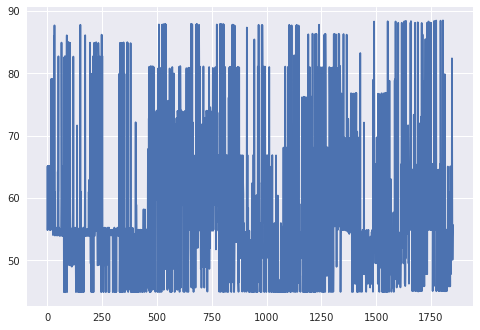

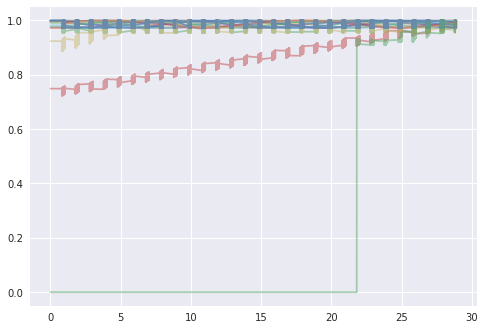

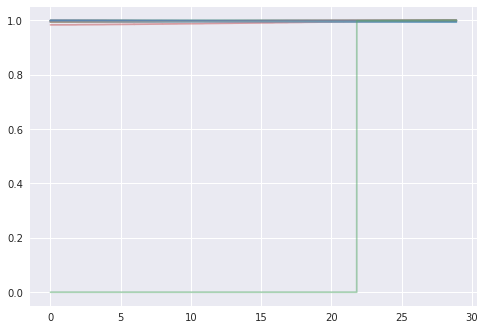

In [15]:
# check size of the data
print(time.shape)
print(angular_momentum_x.shape)
print(np.sum(time[:,0:1] > 1))
i = 180 /np.pi *np.arccos(angular_momentum_z[:,0]/np.sqrt(angular_momentum_x[:,0]**2+angular_momentum_y[:,0]**2+angular_momentum_z[:,0]**2))
plt.figure()
plt.plot(i)
plt.show()
plt.figure()
plt.style.use('seaborn')
for i in range(time[::100].shape[0]):
    plt.plot( time[::100,:][i], radius[::100,:][i], alpha = 0.5)
# plt.ylim([6650,7000])
# plt.ylim([0,2])
plt.show()

plt.figure()
plt.style.use('seaborn')
min_ang = np.min(angular_momentum_mag[np.nonzero(angular_momentum_mag)])
for i in range(time[::100].shape[0]):
    plt.plot( time[::100,:][i], angular_momentum_z[::100,:][i], alpha = 0.5)
# plt.ylim([51000,53000])
# plt.ylim([.9,1])
plt.show()


Num cluster: 2 Sum of squares: 6162202565531349.0
Num cluster: 3 Sum of squares: 4025098985873852.5
Num cluster: 4 Sum of squares: 2594645026885257.0
Num cluster: 5 Sum of squares: 1914201522255908.0
Num cluster: 6 Sum of squares: 1472989020728047.8
Num cluster: 7 Sum of squares: 1224544756500772.2
Num cluster: 8 Sum of squares: 1042622476299803.4
Num cluster: 9 Sum of squares: 871819071092499.6
Num cluster: 10 Sum of squares: 734445401138733.4
Num cluster: 11 Sum of squares: 654936507974830.2
Num cluster: 12 Sum of squares: 587839868882578.9
Num cluster: 13 Sum of squares: 526881602611347.9
Num cluster: 14 Sum of squares: 500338324993521.7
Num cluster: 15 Sum of squares: 448067127736092.1


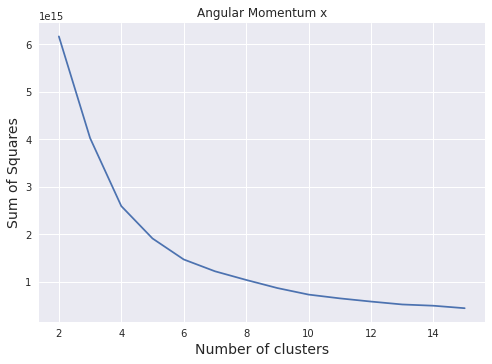

Num cluster: 2 Sum of squares: 6022804224850011.0
Num cluster: 3 Sum of squares: 4027508002992873.0
Num cluster: 4 Sum of squares: 2633815057456500.5
Num cluster: 5 Sum of squares: 1918024250820960.8
Num cluster: 6 Sum of squares: 1435139942592114.8
Num cluster: 7 Sum of squares: 1173780526451563.5
Num cluster: 8 Sum of squares: 954965040128842.5
Num cluster: 9 Sum of squares: 778399270931323.4
Num cluster: 10 Sum of squares: 626884178789182.9
Num cluster: 11 Sum of squares: 546408920267454.06
Num cluster: 12 Sum of squares: 480033324531836.2
Num cluster: 13 Sum of squares: 443980624196402.9
Num cluster: 14 Sum of squares: 406559598901025.9
Num cluster: 15 Sum of squares: 382324014036251.6


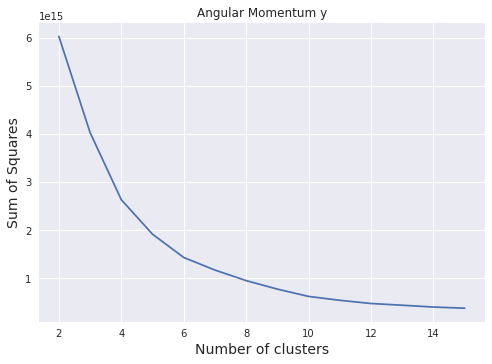

Num cluster: 2 Sum of squares: 334791088175057.7
Num cluster: 3 Sum of squares: 198027802918096.8
Num cluster: 4 Sum of squares: 137548289699594.48
Num cluster: 5 Sum of squares: 101688864636163.89
Num cluster: 6 Sum of squares: 81539935465592.3
Num cluster: 7 Sum of squares: 62552108051406.45
Num cluster: 8 Sum of squares: 52030376140032.14
Num cluster: 9 Sum of squares: 46290969588449.086
Num cluster: 10 Sum of squares: 39823045866934.49
Num cluster: 11 Sum of squares: 34663214794199.445
Num cluster: 12 Sum of squares: 30952460888591.83
Num cluster: 13 Sum of squares: 28413509215578.1
Num cluster: 14 Sum of squares: 26433603939105.336
Num cluster: 15 Sum of squares: 25213510923170.68


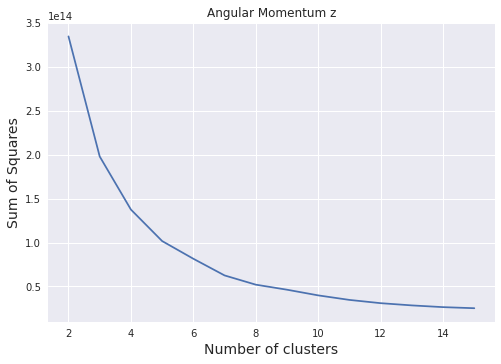

Num cluster: 2 Sum of squares: 101599.29853466144
Num cluster: 3 Sum of squares: 68236.64236211205
Num cluster: 4 Sum of squares: 47887.84450438849
Num cluster: 5 Sum of squares: 28256.594001856196
Num cluster: 6 Sum of squares: 21471.3903078173
Num cluster: 7 Sum of squares: 15114.113380370152
Num cluster: 8 Sum of squares: 10813.275531109039
Num cluster: 9 Sum of squares: 8999.431146847319
Num cluster: 10 Sum of squares: 7257.089258512881
Num cluster: 11 Sum of squares: 6192.7487143071785
Num cluster: 12 Sum of squares: 5398.148295725553
Num cluster: 13 Sum of squares: 4873.712834418215
Num cluster: 14 Sum of squares: 4233.676914031417
Num cluster: 15 Sum of squares: 3622.5882803394848


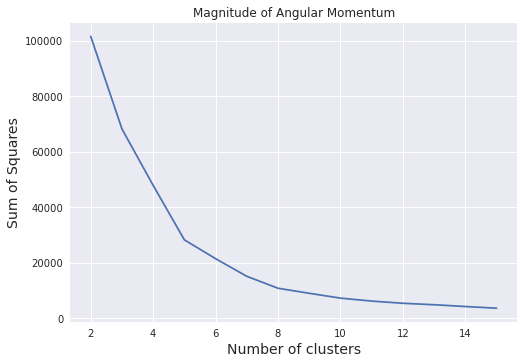

Num cluster: 2 Sum of squares: 100126.32536265352
Num cluster: 3 Sum of squares: 66929.04680841604
Num cluster: 4 Sum of squares: 47517.6972663902
Num cluster: 5 Sum of squares: 28226.508388458915
Num cluster: 6 Sum of squares: 21340.69944765127
Num cluster: 7 Sum of squares: 14831.066352527161
Num cluster: 8 Sum of squares: 10530.781637832419
Num cluster: 9 Sum of squares: 8826.160798383142
Num cluster: 10 Sum of squares: 7138.01105443273
Num cluster: 11 Sum of squares: 6370.58442909442
Num cluster: 12 Sum of squares: 5658.260975825518
Num cluster: 13 Sum of squares: 5009.15757548858
Num cluster: 14 Sum of squares: 4493.115222465079
Num cluster: 15 Sum of squares: 4120.593953636961


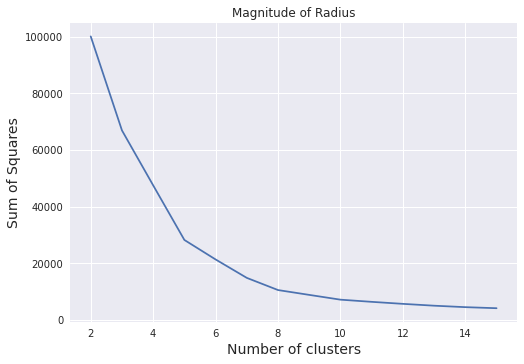

Num cluster: 2 Sum of squares: 626358304.477085
Num cluster: 3 Sum of squares: 449847853.3314736
Num cluster: 4 Sum of squares: 322549496.7149018
Num cluster: 5 Sum of squares: 261836048.41800302
Num cluster: 6 Sum of squares: 210481667.26886404
Num cluster: 7 Sum of squares: 186959082.36907968
Num cluster: 8 Sum of squares: 159568057.6856028
Num cluster: 9 Sum of squares: 137492685.27386135
Num cluster: 10 Sum of squares: 119350422.82386109
Num cluster: 11 Sum of squares: 103815983.89992853
Num cluster: 12 Sum of squares: 93724820.84174973
Num cluster: 13 Sum of squares: 78778562.00857845
Num cluster: 14 Sum of squares: 69572747.29068434
Num cluster: 15 Sum of squares: 60834070.8690797


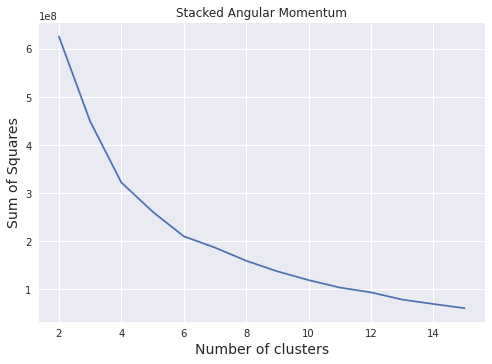

In [8]:
# Generates the k-means elbow plot to check the optimal number of clusters on Radius
num_clusters = 15


list_var = ['x','y','z']
for i in range(3):
    kmeans_elbow(position[:,:,i],num_clusters,'Position '+list_var[i],0)
    kmeans_elbow(angular_momentum[:,:,i],num_clusters,'Angular Momentum '+list_var[i])
kmeans_elbow(angular_momentum_mag,num_clusters, 'Magnitude of Angular Momentum')
kmeans_elbow(radius, num_clusters, 'Magnitude of Radius')

kmeans_elbow(angular_momentum_stacked,num_clusters,'Stacked Angular Momentum')
kmeans_elbow(position_stacked,num_clusters,'Stacked Position',0)

For n_clusters = 2 The average silhouette_score is : 0.9685576063872476
For n_clusters = 3 The average silhouette_score is : 0.9673314286319793
For n_clusters = 4 The average silhouette_score is : 0.9789346392035284
For n_clusters = 5 The average silhouette_score is : 0.9763375656686409
For n_clusters = 6 The average silhouette_score is : 0.9799468522638506
For n_clusters = 7 The average silhouette_score is : 0.9810430645506223
For n_clusters = 8 The average silhouette_score is : 0.9819604557446476
For n_clusters = 9 The average silhouette_score is : 0.9824036450713352
For n_clusters = 10 The average silhouette_score is : 0.9827646468499215
For n_clusters = 11 The average silhouette_score is : 0.9828527951189757
For n_clusters = 12 The average silhouette_score is : 0.9829165887821667
For n_clusters = 13 The average silhouette_score is : 0.9835171666313955
For n_clusters = 14 The average silhouette_score is : 0.9837041856924447
For n_clusters = 15 The average silhouette_score is : 0.983

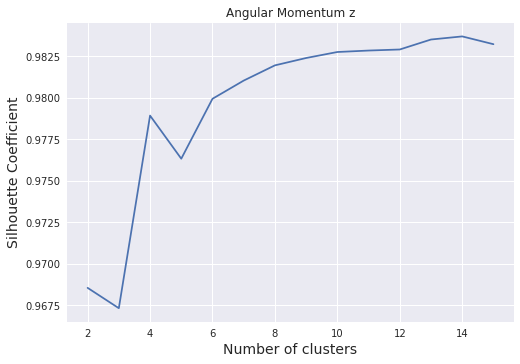

For n_clusters = 2 The average silhouette_score is : 0.9398284547341439
For n_clusters = 3 The average silhouette_score is : 0.9348601997018275
For n_clusters = 4 The average silhouette_score is : 0.9470427655298523
For n_clusters = 5 The average silhouette_score is : 0.8538553825101396
For n_clusters = 6 The average silhouette_score is : 0.8407423649467601
For n_clusters = 7 The average silhouette_score is : 0.8420902698853014
For n_clusters = 8 The average silhouette_score is : 0.8436120230322479
For n_clusters = 9 The average silhouette_score is : 0.8448556251462473
For n_clusters = 10 The average silhouette_score is : 0.7857124978907857
For n_clusters = 11 The average silhouette_score is : 0.7862311072347778
For n_clusters = 12 The average silhouette_score is : 0.7862178814680386
For n_clusters = 13 The average silhouette_score is : 0.7880476868087153
For n_clusters = 14 The average silhouette_score is : 0.7861387770855166
For n_clusters = 15 The average silhouette_score is : 0.786

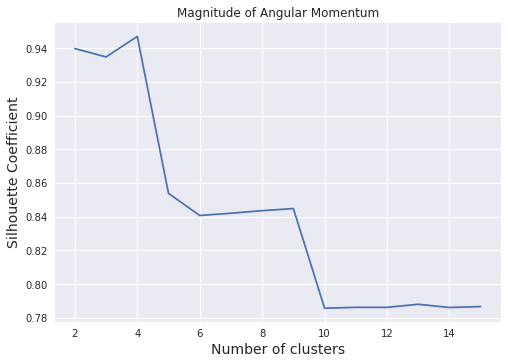

For n_clusters = 2 The average silhouette_score is : 0.9389476296008519
For n_clusters = 3 The average silhouette_score is : 0.9341738981245965
For n_clusters = 4 The average silhouette_score is : 0.8336956084501916
For n_clusters = 5 The average silhouette_score is : 0.843306429149268
For n_clusters = 6 The average silhouette_score is : 0.8306391191922267
For n_clusters = 7 The average silhouette_score is : 0.8315713536330551
For n_clusters = 8 The average silhouette_score is : 0.8332924570638487
For n_clusters = 9 The average silhouette_score is : 0.8343826724617722
For n_clusters = 10 The average silhouette_score is : 0.7699473670023548
For n_clusters = 11 The average silhouette_score is : 0.7628867820085078
For n_clusters = 12 The average silhouette_score is : 0.7607966194294976
For n_clusters = 13 The average silhouette_score is : 0.7624438833094629
For n_clusters = 14 The average silhouette_score is : 0.762562512139623
For n_clusters = 15 The average silhouette_score is : 0.76198

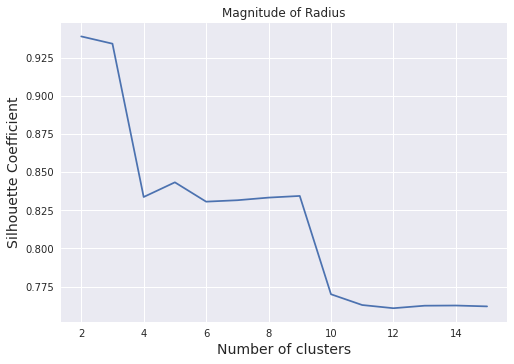

In [9]:
n = 15
kmeans_silho(angular_momentum_z,n,'Angular Momentum z')
kmeans_silho(angular_momentum_mag,n, 'Magnitude of Angular Momentum')
kmeans_silho(radius, n, 'Magnitude of Radius')

In [16]:
def plot_time_clusters(cluster: np.ndarray, num_clusters: int, 
            angular_momentum_x: np.ndarray,
            angular_momentum_y: np.ndarray,
            angular_momentum_z: np.ndarray,
            time: np.ndarray, axis: int):
    '''
    plots angular momentum and their clusters as a function of time 
    '''
    fig = plt.figure(figsize= (15,15))
    fig, axs =plt.subplots(3,1, sharex= True)
    for i in range(0,num_clusters):
        title = "cluster" + str(i)
        if axis == 0:
            time_tmp = time[cluster == i]
            angular_momentum_x_tmp = angular_momentum_x[cluster == i]
            angular_momentum_y_tmp = angular_momentum_y[cluster == i]
            angular_momentum_z_tmp = angular_momentum_z[cluster == i]
            ind  = np.dstack(np.random.choice(time_tmp.shape[0],1))
        elif axis == 1:
            time_tmp = time[:,cluster == i]
            angular_momentum_x_tmp = angular_momentum_x[:,cluster == i]
            angular_momentum_y_tmp = angular_momentum_y[:,cluster == i]
            angular_momentum_z_tmp = angular_momentum_z[:,cluster == i]
            ind = 92
        axs[0].scatter(time_tmp[ind,:],angular_momentum_x_tmp[ind,:])
        axs[0].set_ylabel('h_x')
        axs[1].scatter(time_tmp[ind,:],angular_momentum_y_tmp[ind,:])
        axs[1].set_ylabel('h_y')
        axs[2].scatter(time_tmp[ind,:],angular_momentum_z_tmp[ind,:],label = title)
        axs[2].set_ylabel('h_z')
        axs[2].legend()

In [17]:
def plot_clusters_3d( time_point: int, 
    clusters: np.ndarray, num_clusters: int,           
            angular_momentum_x: np.ndarray,
            angular_momentum_y: np.ndarray,
            angular_momentum_z: np.ndarray,  axis: int):
    '''
    Plots data in 3d scatter plot. Each cluster is colored differently and labelled.
    '''
    plt.cla()
    if axis == 0:
        for i in range(0,num_clusters):
            title = "Cluster" + str(i)
            # ind  = np.arange(0,angular_momentum_x[clusters == i].shape[1],100)notebook
            ind = time_point
            ax.scatter(angular_momentum_x[clusters == i][:,ind],
                       angular_momentum_y[clusters == i][:,ind],
                       angular_momentum_z[clusters == i][:,ind], s = 20 , label = title)
    elif axis == 1:
        for i in range(0,num_clusters):
            title = "Cluster" + str(i)
            ind  = np.arange(0,angular_momentum_x[:,clusters == i].shape[0],100)
            ind = 920
            #ind = time_point
            ax.scatter(angular_momentum_x[:,clusters == i][ind],
                       angular_momentum_y[:,clusters == i][ind],
                       angular_momentum_z[:,clusters == i][ind], s = 40 , label = title)
    ax.set_xlabel('h_x')
    ax.set_ylabel('h_y')
    ax.set_zlabel('h_z')
#     ax.set_xlim([-50000, 50000])
#     ax.set_ylim([-50000, 50000])
#     ax.set_zlim([29500, 32000])
    ax.legend()

In [18]:
def ts_cluster_plot(time: np.ndarray,
            data: np.ndarray, 
            num_cluster: int, 
            cluster_labels: np.ndarray, 
            cluster_centers: np.ndarray, 
            dimension: int,
            ylabel: str):
    '''
    Plot the time-series data and the cluster center in each cluster. 
    '''

    plt.style.use("seaborn")
    for i in range(num_cluster):
        # Plot all the clusters in a subplot
        if dimension == 1:
            plt.subplot(num_cluster//3+1, 3, i+1)
            
            for t,ts in zip(time[cluster_labels == i], data[cluster_labels == i]):
                plt.plot(t,ts, "k-", linewidth=0.1)

            plt.plot(t,cluster_centers[i, :], "r-")

            plt.title("Cluster " + str(i+1))
            plt.xlabel('Time in Days')
            plt.ylabel(ylabel)
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
        # Plot 1 cluster on each row of subplot with each physical quantity in a column
        else:
            for j in range(dimension):
                plt.subplot(num_cluster, dimension, i*dimension+j+1)
                
                for ts in data[cluster_labels == i][:, :, j]:
                    plt.plot(ts, "k-", linewidth=0.1)

                plt.plot(cluster_centers[i, :, j], "r-")

                plt.xticks(fontsize=8)
                plt.yticks(fontsize=8)

                if i == 0 and j == 0:
                    plt.title("Angular Momentum in x-direction", fontsize=8)
                elif i == 0 and j == 1:
                    plt.title("Angular Momentum in y-direction", fontsize=8)
                elif i == 0 and j == 2:
                    plt.title("Angular Momentum in z-direction", fontsize=8)
            plt.figtext(0.5, 1-(i*(1/num_cluster+0.01)), "Cluster " + str(i+1))

In [19]:
# Runs K-means on the optimal number of clusters determined from the elbow plot
num_clusters = 7

hx_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_x)
hy_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_y)

h_stack_kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(angular_momentum_stacked)


hx_clusters = hx_kmeans.labels_
hy_clusters = hy_kmeans.labels_

h_stack_clusters = h_stack_kmeans.labels_


In [20]:
def kmeans_optimal(time,data,optimal_cluster,dim, ylabel):
    data_kmeans= KMeans(n_clusters=optimal_cluster, random_state=0).fit(data)
    out_clusters = data_kmeans.labels_
    out_clusters_centers = data_kmeans.cluster_centers_
    print('Cluster silhouette score:',metrics.silhouette_score(data,out_clusters))

    plt.figure(figsize=(14, 7), dpi=150)
    ts_cluster_plot(time,data, 
                optimal_cluster, 
                out_clusters, 
                out_clusters_centers, 
                dim,
                ylabel)
    return out_clusters,data_kmeans

Clustering on Radius
Cluster silhouette score: 0.843306429149268


<Figure size 2100x2250 with 0 Axes>

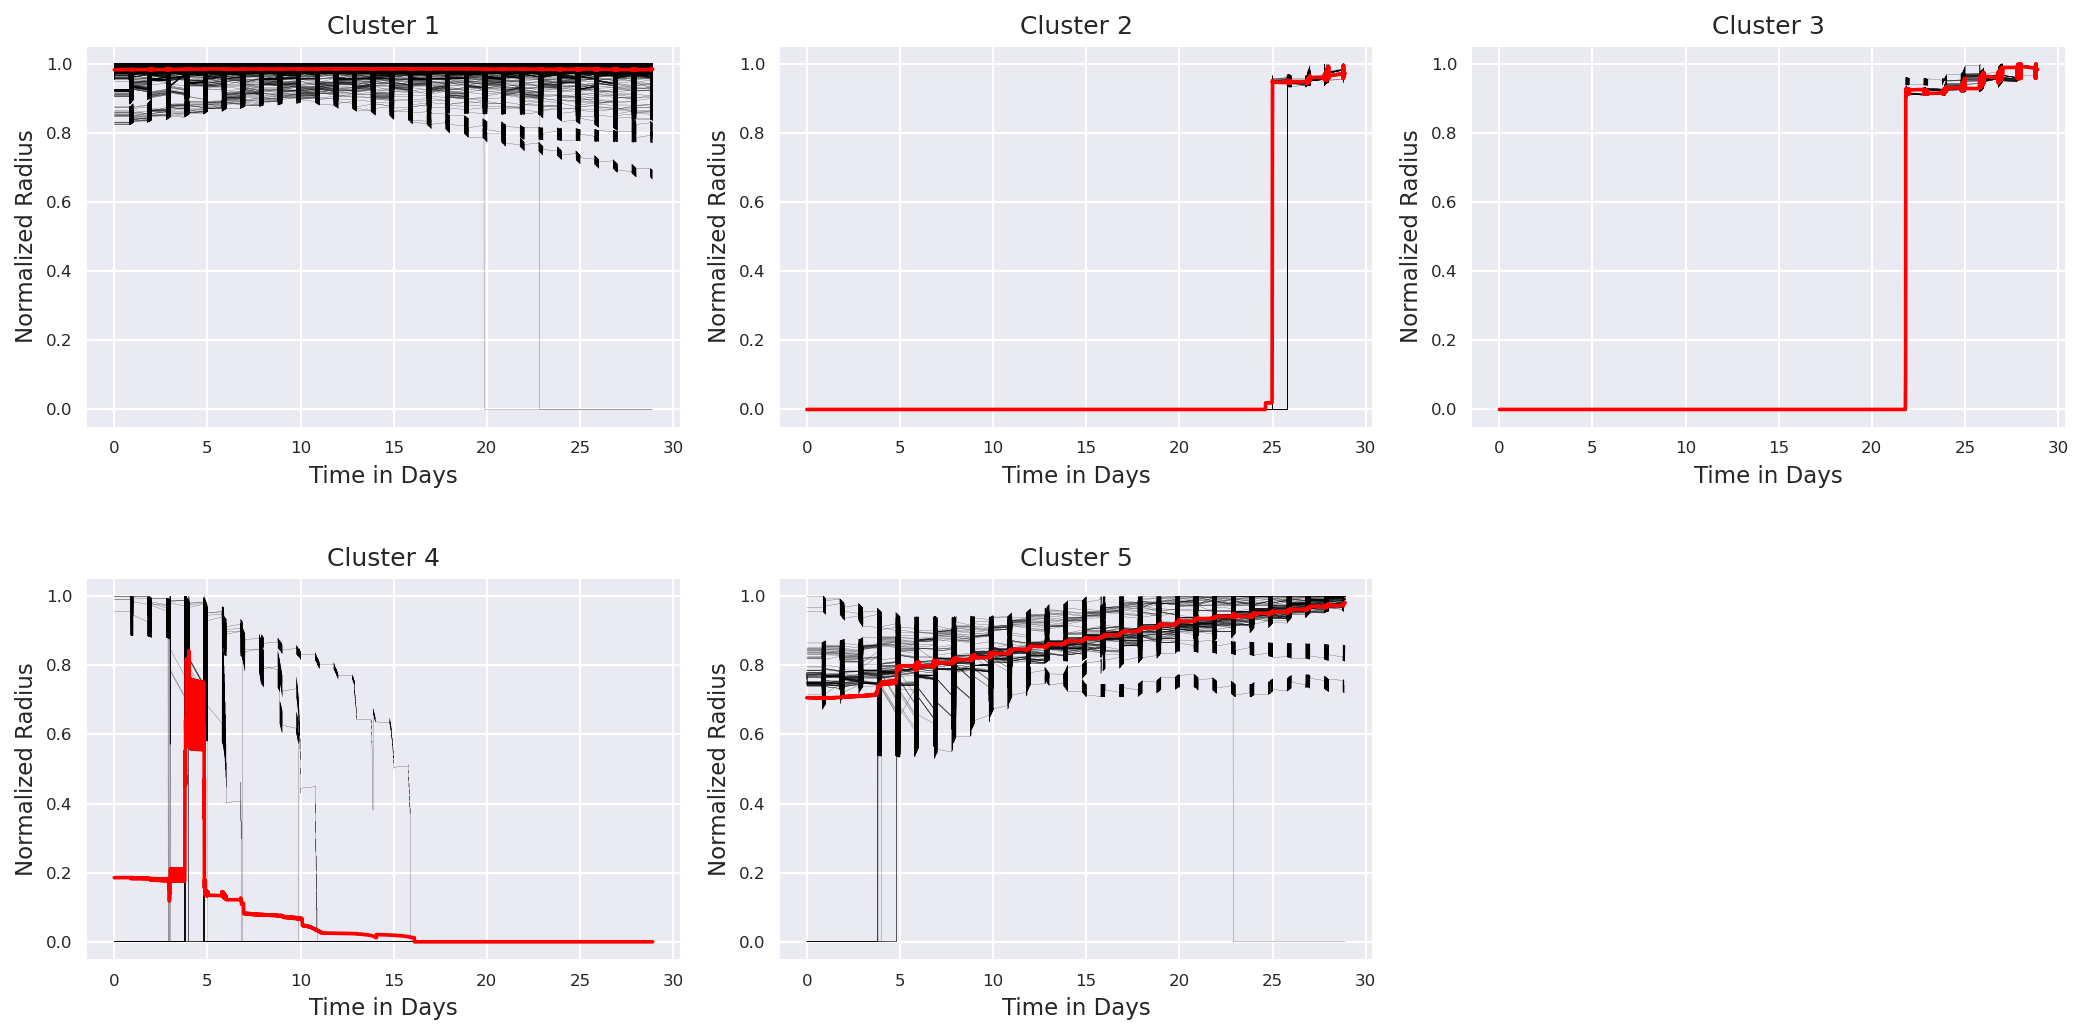

In [30]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_R = 5
print('Clustering on Radius')
r_clusters, radius_kmeans = kmeans_optimal(time,radius,optimal_cluster_R,1,'Normalized Radius')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


Clustering on Angular Momentum z
Cluster silhouette score: 0.9810430645506223


<Figure size 2100x2250 with 0 Axes>

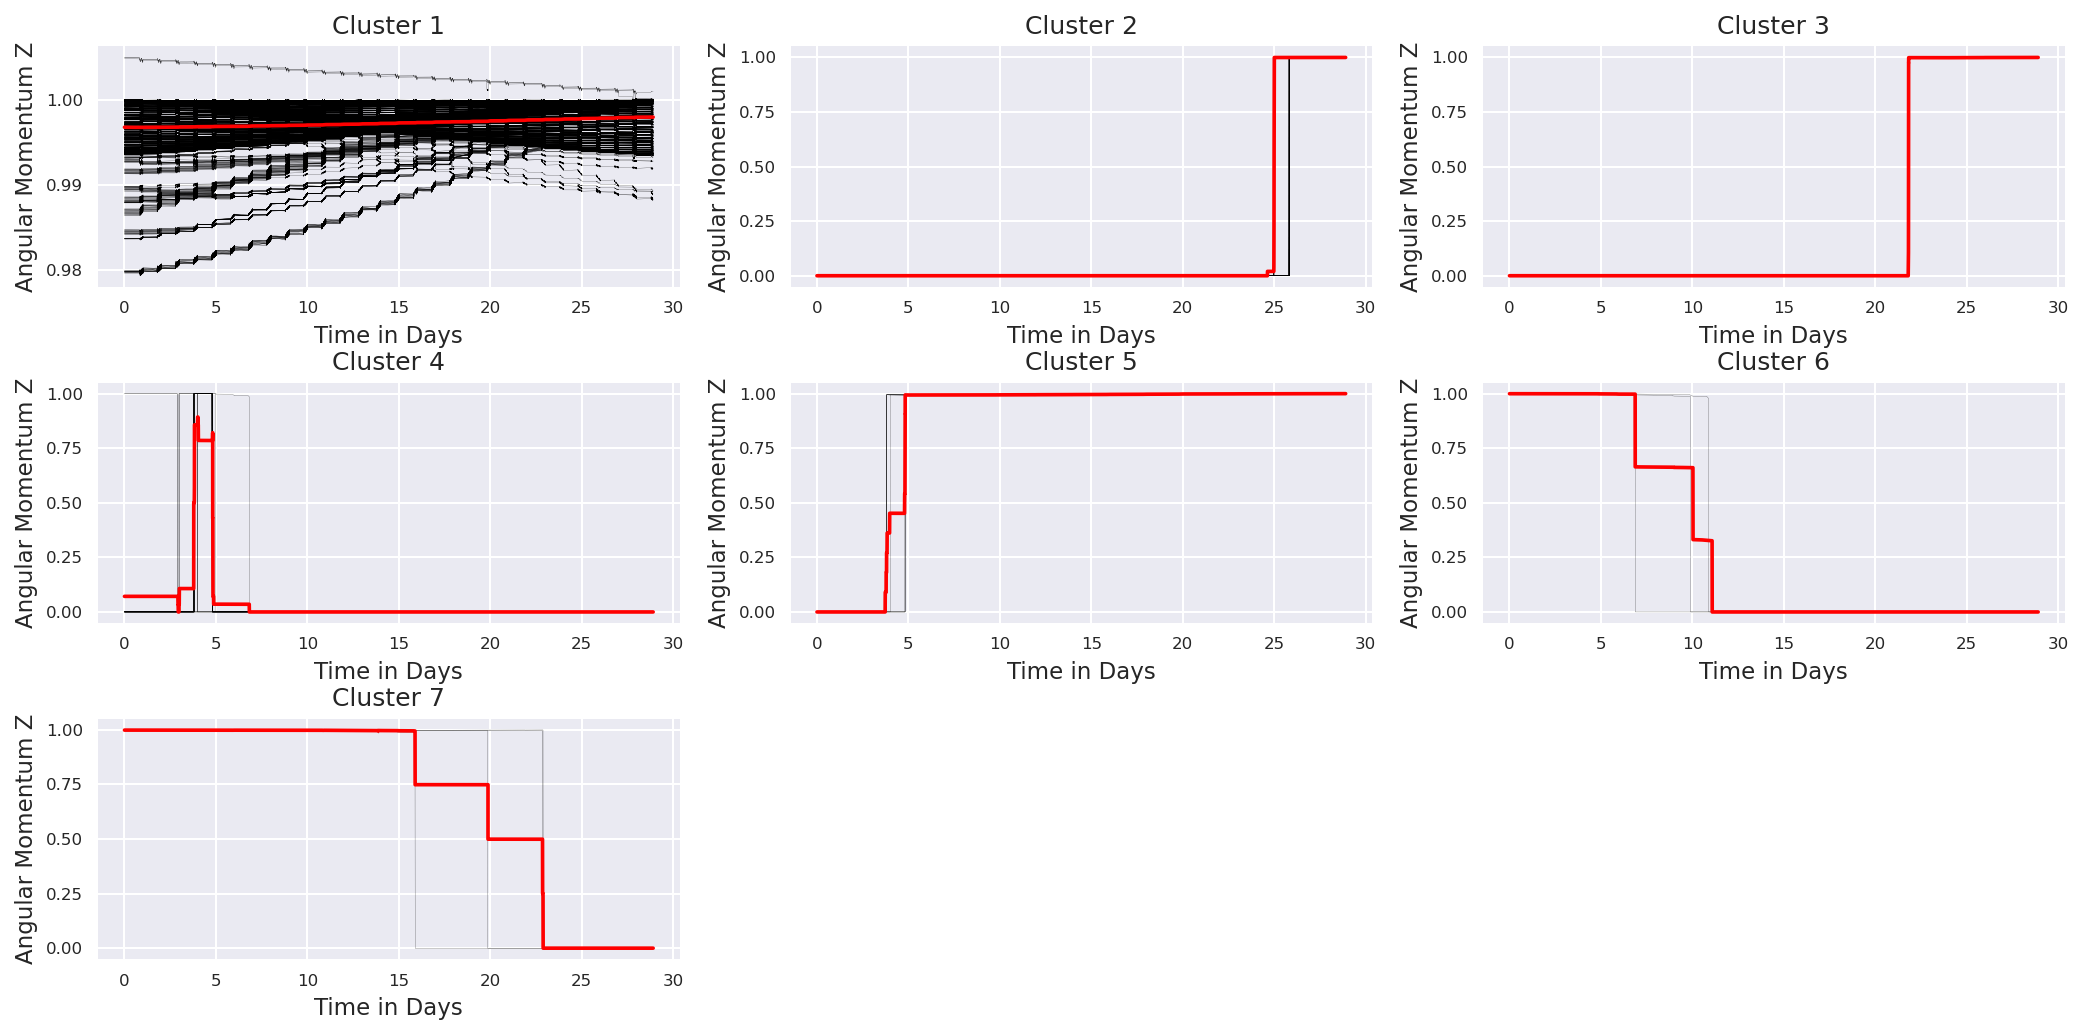

In [28]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_hz = 7
print('Clustering on Angular Momentum z')
hz_clusters,hz_kmeans = kmeans_optimal(time,angular_momentum_z,optimal_cluster_hz,1,'Angular Momentum Z')
plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.show()

Clustering on Angular momentum Magnitude
Cluster silhouette score: 0.9470427655298523


<Figure size 2100x2250 with 0 Axes>

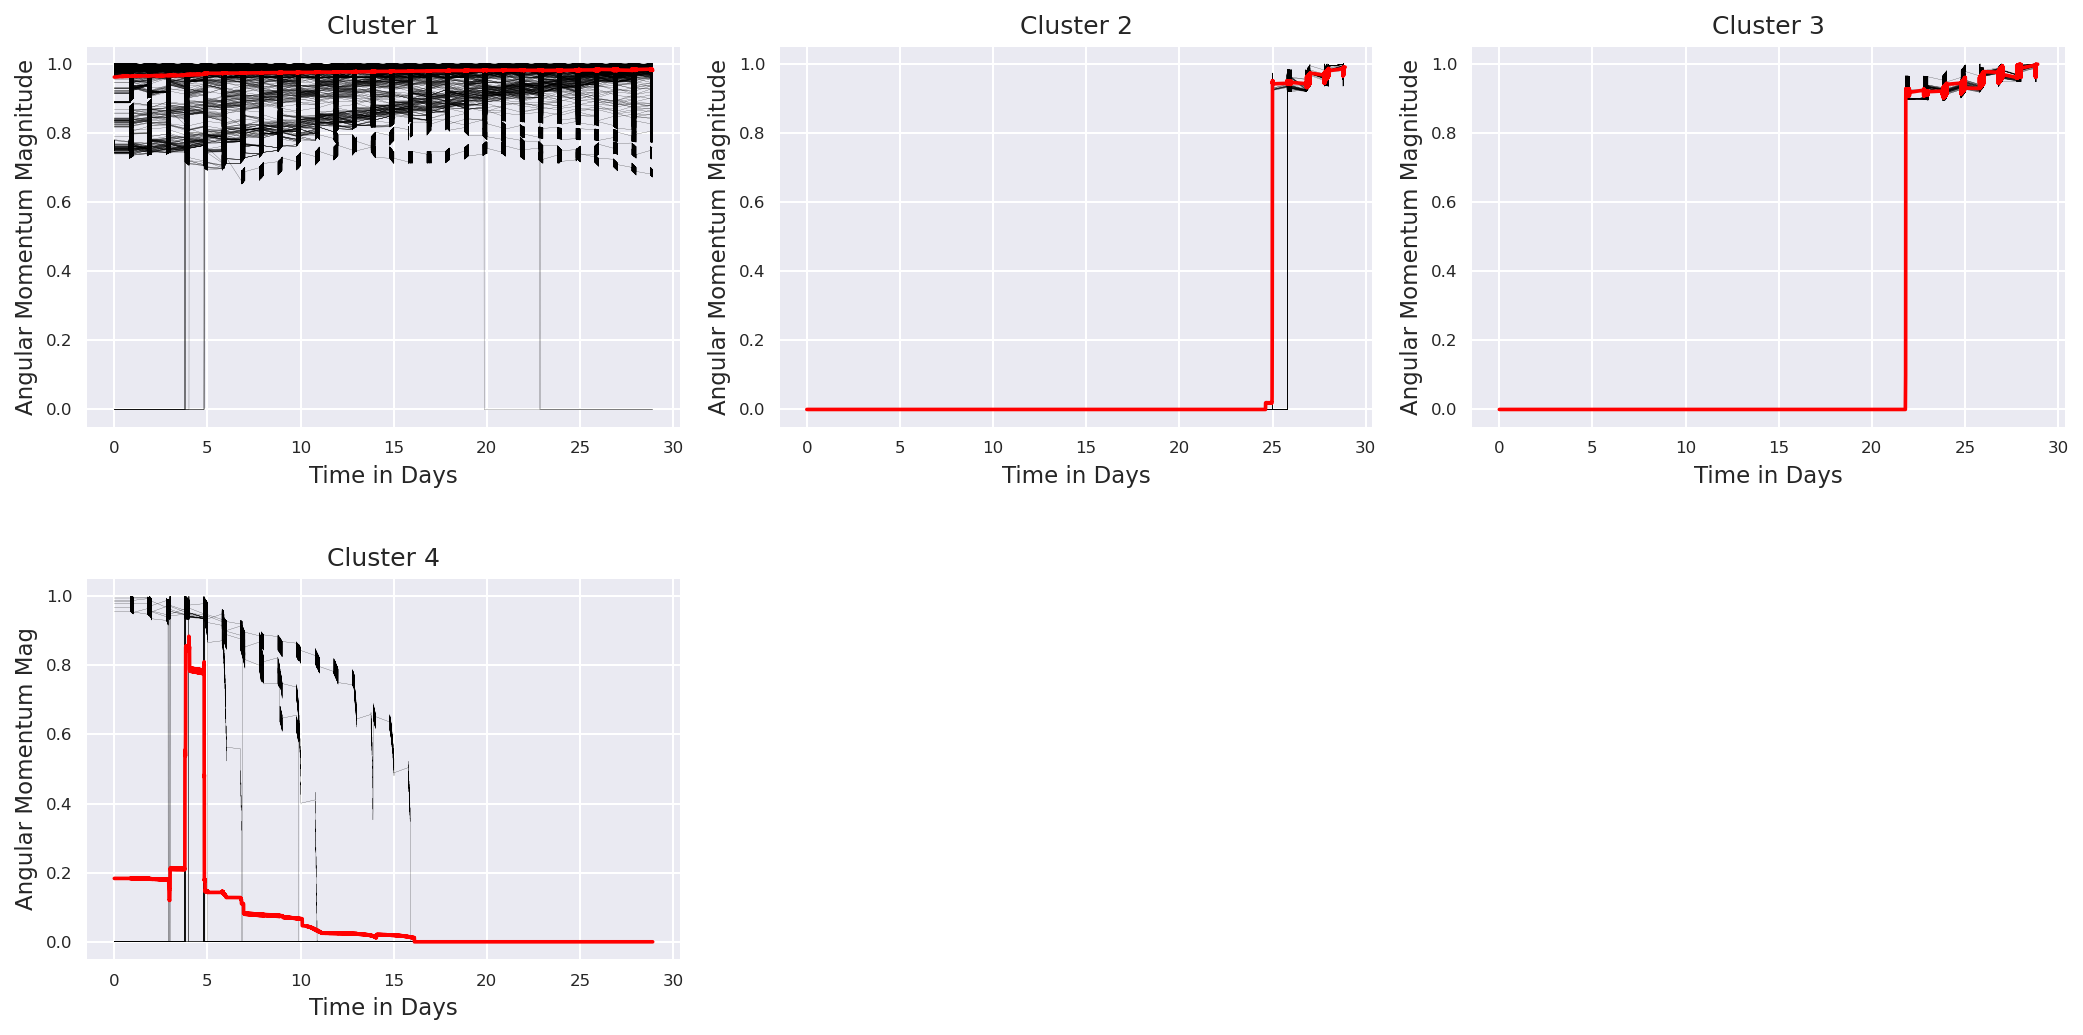

In [29]:
%matplotlib inline
plt.figure(figsize=(14, 15), dpi=150)
optimal_cluster_hmag = 4
print('Clustering on Angular momentum Magnitude')
h_clusters,h_kmeans = kmeans_optimal(time,angular_momentum_mag,optimal_cluster_hmag,1,'Angular Momentum Magnitude')
plt.ylabel('Angular Momentum Mag')
plt.xlabel('Time in Days')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


In [24]:
data_list = [angular_momentum_x, angular_momentum_y,angular_momentum_z, angular_momentum_mag,
             angular_momentum_stacked, radius]
cluster_list = [hx_clusters,hy_clusters,hz_clusters, h_clusters,h_stack_clusters,r_clusters]
cluster_list_name =[ 'Angular Momentum x', 'Angular Momentum y', 'Angular Momentum z', 'Angular Momentum Magnitude', 
                   'Angular Momentum Stacked', 'Radius']


/tmp/ipykernel_21008/818662101.py:9: RuntimeWarning: Mean of empty slice
  radius_mean[i,:] = np.nanmean(human_radius[human_cluster_labels==i,:],axis =0)


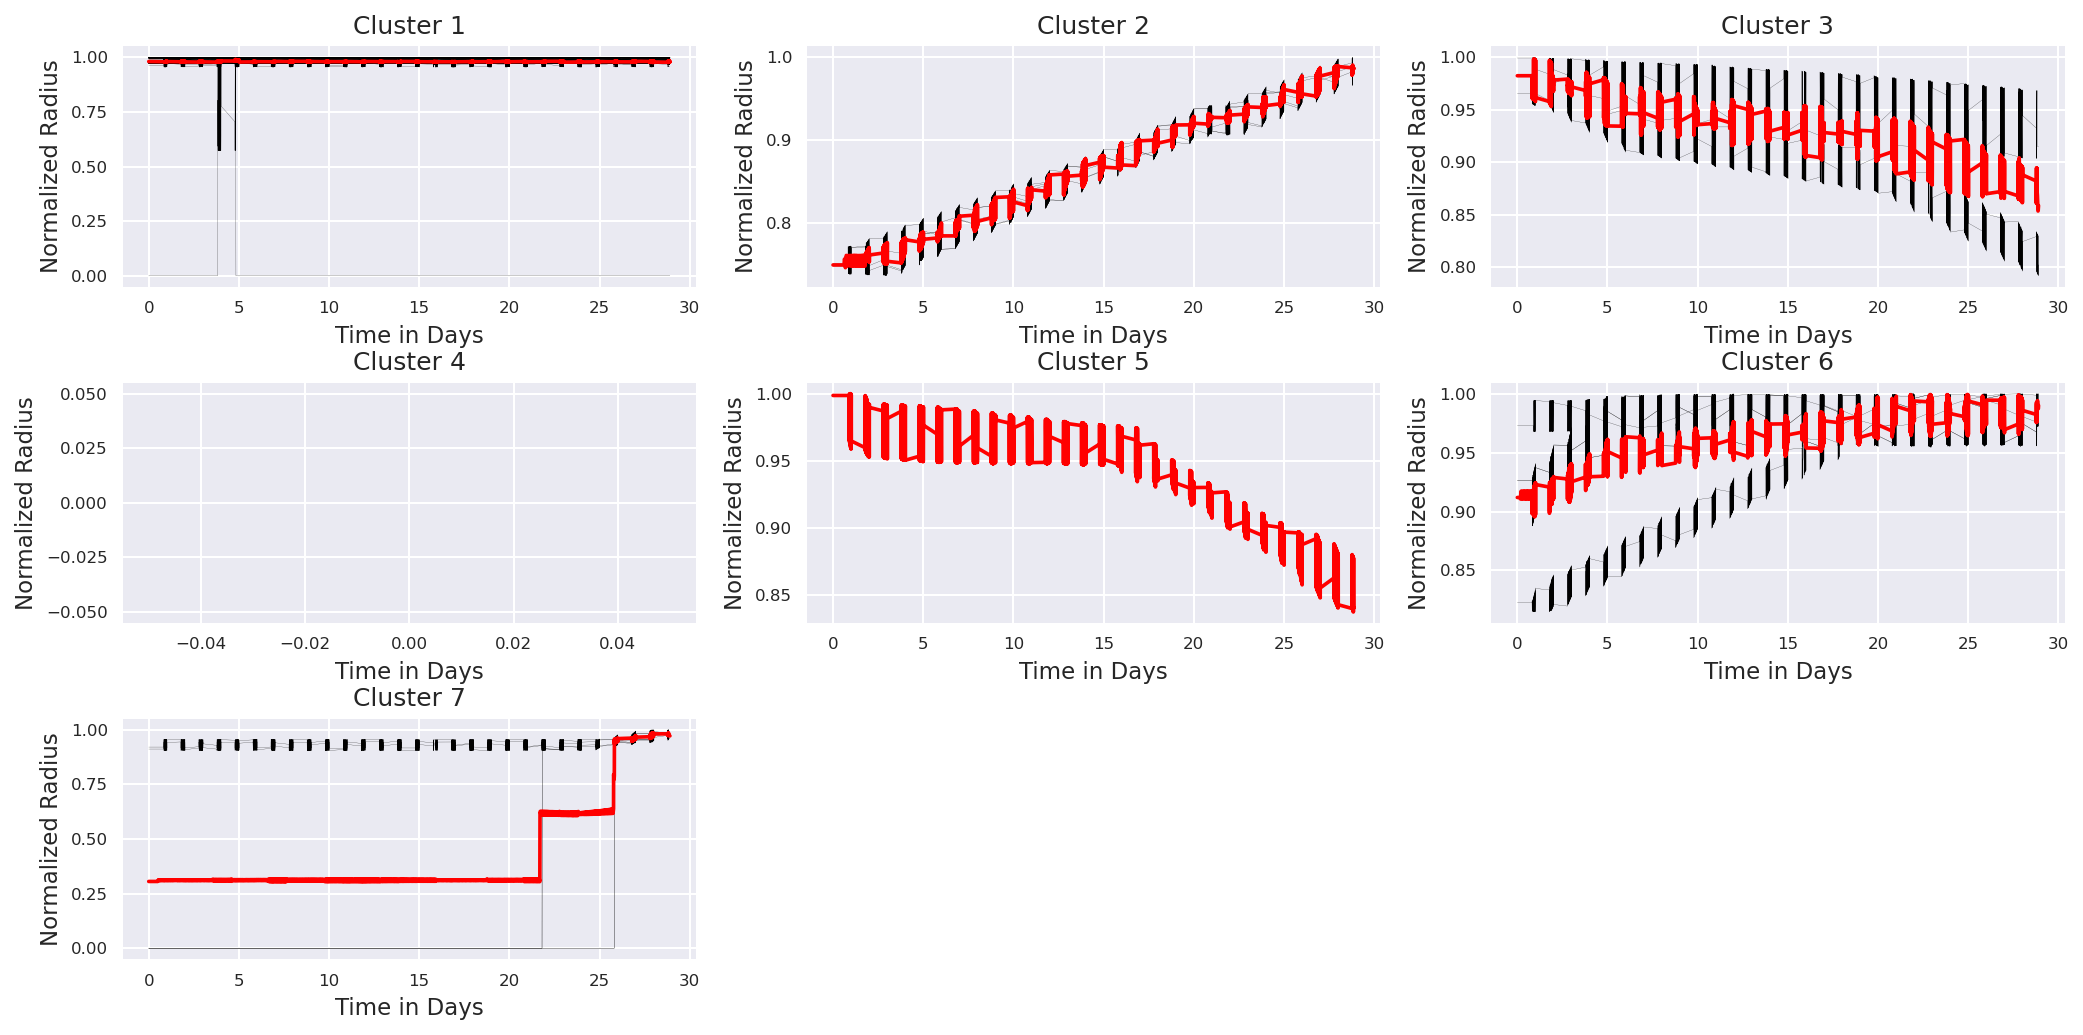

In [25]:
human_cluster = np.loadtxt('labels.txt',dtype = int)

radius_mean = np.zeros([7,8018])
human_radius = radius[human_cluster[:,0]].copy()
human_cluster_labels =human_cluster[:,1]
for i in range(0,7):
    title = "Cluster" + str(i)
    # calculates the mean position and time between each satellite
    radius_mean[i,:] = np.nanmean(human_radius[human_cluster_labels==i,:],axis =0)
plt.figure(figsize=(14, 7), dpi=150)
ts_cluster_plot(time[human_cluster[:,0]],human_radius, 
            7,
            human_cluster_labels, 
            radius_mean, 
            1,
            'Normalized Radius')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [26]:
silhouette_score = np.zeros(len(cluster_list))
ami= np.zeros(len(cluster_list))
for i in range(len(cluster_list)):
    kmeans_labels = cluster_list[i][human_cluster[:,0]]
    human_labels = human_cluster[:,1]
    ami[i] = metrics.adjusted_mutual_info_score(human_labels, kmeans_labels)
    silhouette_score[i] = metrics.silhouette_score(data_list[i],cluster_list[i])
    print("For " +cluster_list_name[i]+ '=', num_clusters, "The average silhouette score is:",silhouette_score[i],
         "The Adjusted Mutual Info score is:",ami[i])

For Angular Momentum x= 7 The average silhouette score is: 0.6360153871912836 The Adjusted Mutual Info score is: -0.04160892758213759
For Angular Momentum y= 7 The average silhouette score is: 0.6259217642472982 The Adjusted Mutual Info score is: -0.010251099858139536
For Angular Momentum z= 7 The average silhouette score is: 0.9810430645506223 The Adjusted Mutual Info score is: 0.2426873091234045
For Angular Momentum Magnitude= 7 The average silhouette score is: 0.8420902698853014 The Adjusted Mutual Info score is: 0.4595265454893526
For Angular Momentum Stacked= 7 The average silhouette score is: 0.6443977287734289 The Adjusted Mutual Info score is: -0.02721612428115483
For Radius= 7 The average silhouette score is: 0.8315713536330551 The Adjusted Mutual Info score is: 0.4595265454893526


In [27]:
print(metrics.silhouette_score(angular_momentum_z,hz_clusters))

0.9810430645506223


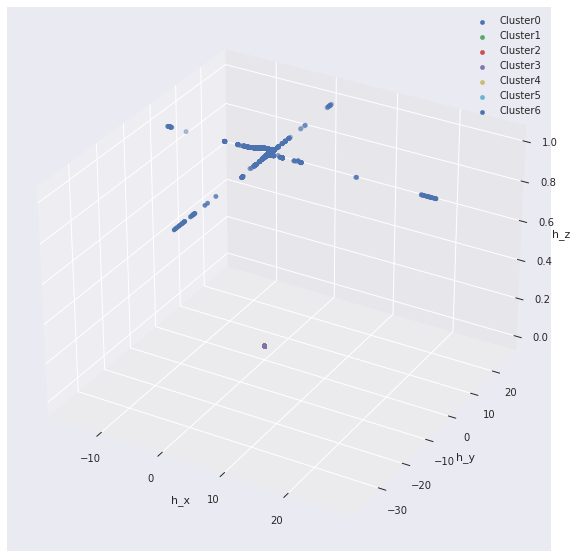

In [43]:
# Plots in 3d angular momentum vector of each satellite coloring based on cluster at a time point
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
plot_clusters_3d(0,hz_clusters,num_clusters,angular_momentum_x,angular_momentum_y,angular_momentum_z,0)
# plot_clusters_3d(0,r_clusters,num_clusters,position[:,:,0:1],position[:,:,1:2],position[:,:,2:3],0)
plt.ion()
plt.show()

In [1]:
plt.close()
# Generates an animation for time evolution of angular momentum vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')
anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time[:,::24].shape[1], 
                                interval=20, 
                                fargs=(hz_clusters,num_clusters,angular_momentum_x[:,::24],
                                                    angular_momentum_y[:,::24],
                                                    angular_momentum_z[:,::24],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.close()
# Generates an animation for time evolution of angular momentum vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')
anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time.shape[1], 
                                interval=20, 
                                fargs=(r_clusters,num_clusters,position[:,:,0:1],
                                                    position[:,:,1:2],
                                                    position[:,:,2:3],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

In [ ]:
plt.close()
# Generates an animation for time evolution of position vector
print(time[:,::24].shape[1])
ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(ts_fig, 
                                plot_clusters_3d, 
                                frames=time.shape[1], 
                                interval=20, 
                                fargs=(r_clusters,num_clusters,position[:,:,0:1],
                                                    position[:,:,1:2],
                                                    position[:,:,2:3],0),
                                blit=True,
                                repeat_delay=200)
plt.show()

In [1]:
for i in range(num_clusters):
    print(np.sum(hz_clusters ==i))

NameError: name 'num_clusters' is not defined

In [57]:
def plot_time_clusters(num_clusters, data,time,kmeans,ax):
    '''
    plots each cluster separately with its mean for a given 
    '''
    clusters = kmeans.labels_
    data[data ==(3*Earth_r)**2] = np.nan
    for i in range(0,num_clusters):
        title = "Cluster" + str(i)
        # calculates the mean position and time between each satellite
        radius_mean = np.nanmean(data[clusters==i,:],axis =0)
        time_mean = np.nanmean(time[clusters==i,:],axis =0)
        # scatter plots each satellites value as a function of time
        ax[i].scatter(time[clusters==i,:],data[clusters==i,:],color = "blue",s =1)
        ax[i].plot(time_mean,radius_mean,color = "red")
        ax[i].set_title(title)
        ax[i].set_ylim([np.nanmin(data[clusters==i,:])-50, np.nanmax(data[clusters==i,:])+50])

/tmp/ipykernel_3214262/1482557777.py:10: RuntimeWarning: Mean of empty slice
  radius_mean = np.nanmean(data[clusters==i,:],axis =0)


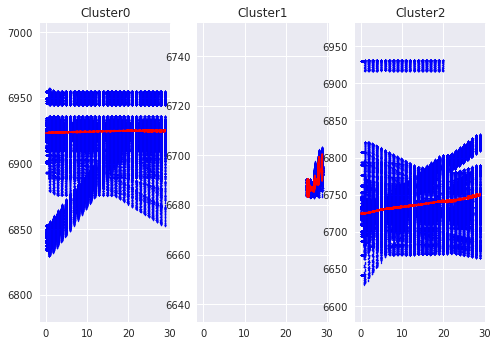

In [61]:
fig,ax = plt.subplots(nrows=1,ncols =3, sharex=True)
ax = ax.ravel()
plot_time_clusters(optimal_cluster_R, radius,time,radius_kmeans,ax)

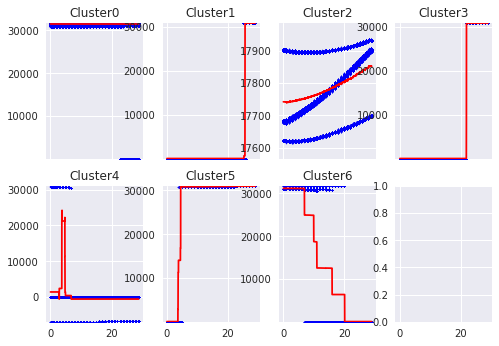

In [63]:
fig,ax = plt.subplots(nrows=2,ncols =4, sharex=True)
ax = ax.ravel()
plot_time_clusters(optimal_cluster_hz, angular_momentum_z,time,hz_kmeans,ax)

In [13]:
np.save('radius_clusters.npy',r_clusters)

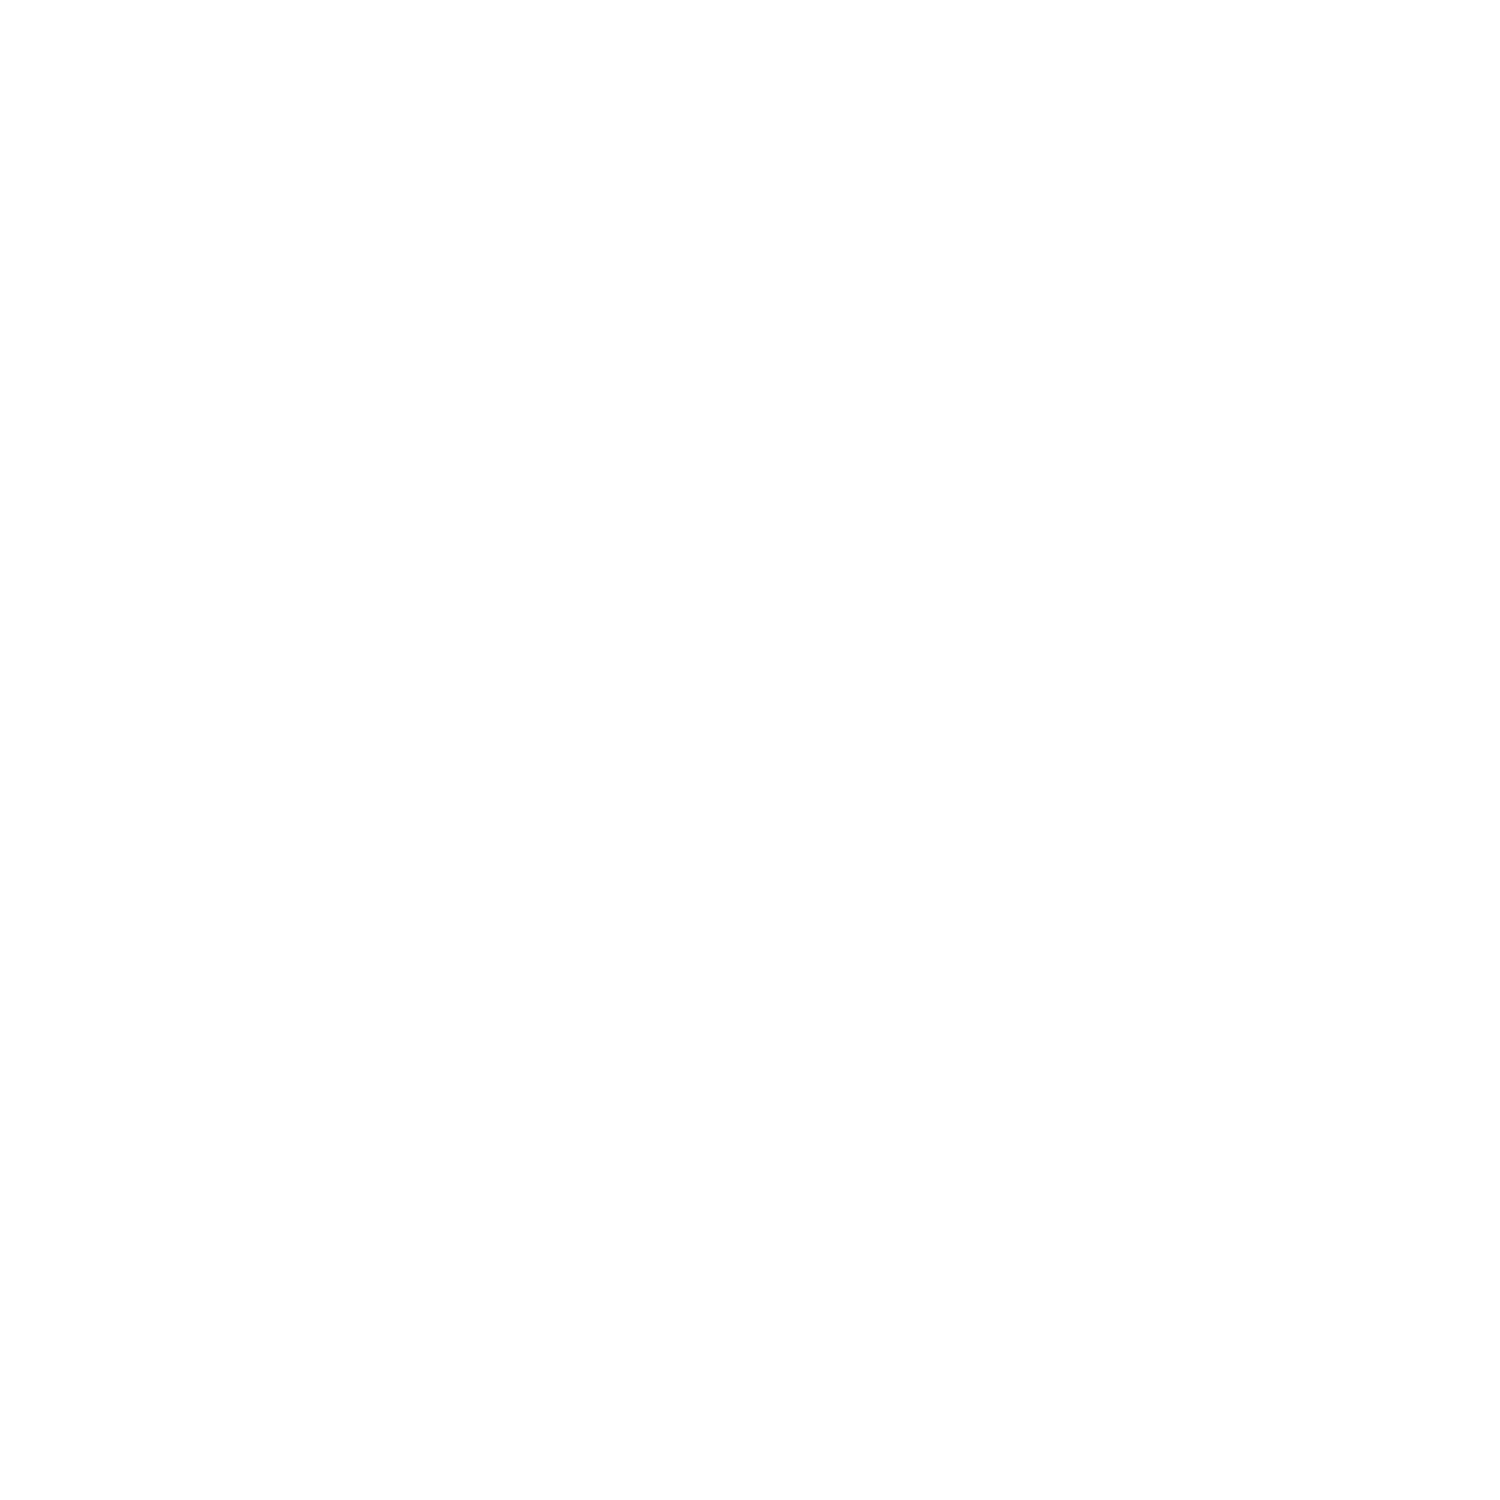

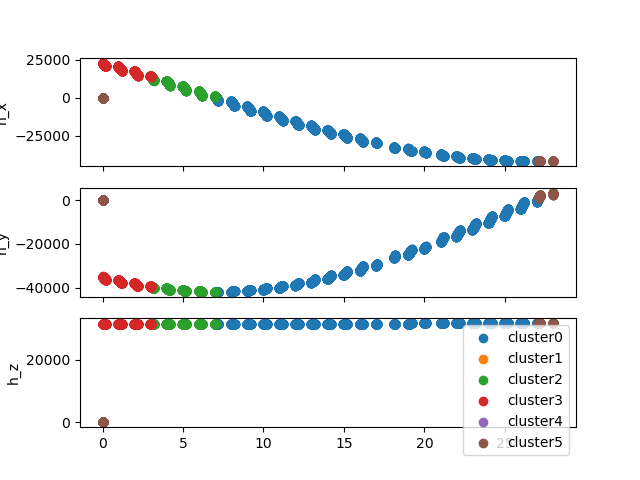

In [ ]:
radius = np.linalg.norm(starlink_data[:, :, 1:4], axis=2)
print(radius.shape)

kmeans_elbow(radius, num_cluster=20)